In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow as tf
import seaborn as sns
from read_data import loadData

print(f'Seaborn: ', sns.__version__)
print(f'TensorFlow: ', tf.__version__)

Seaborn:  0.13.0
TensorFlow:  2.13.0


In [2]:
data_train, testDatasets, expectedRulDatasets = loadData()
drop_col = ['setting_1', 'setting_2', 'setting_3'] 
data_clean = [data.drop(columns = drop_col) for data in data_train]

In [3]:
df = pd.DataFrame()
for i in range(4):
    df =pd.concat([df, data_clean[i]])

In [4]:
def add_label(df_all, max_perc):
    for engine in list(set(df_all['engine'])):
        max_cycle = df_all[df_all['engine'] == engine]['cycle'].max() 
        condition = (df_all['engine'] == engine) & (df_all['cycle'] > max_cycle*max_perc)
        df_all.loc[condition, 'label'] = 1
    df_all = df_all.fillna(0)
    return df_all

In [5]:
df = add_label(df, 0.9)

In [6]:
df['label'].value_counts()

label
0.0    152410
1.0      7949
Name: count, dtype: int64

In [7]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 

In [8]:
df2 = df.copy()
label_corr = df2.drop(columns=['cycle']).corr()['label']

In [9]:
label_corr

engine                                  0.055260
Fan_inlet_temperature_R                -0.024953
LPC_outlet_temperature_R               -0.021844
HPC_outlet_temperature_R               -0.006595
LPT_outlet_temperature_R               -0.001750
Fan_inlet_Pressure_psia                -0.025429
bypass_duct_pressure_psia              -0.025781
HPC_outlet_pressure_psia               -0.022465
Physical_fan_speed_rpm                 -0.019060
Physical_core_speed_rpm                -0.005345
Engine_pressure_ratioP50_P2            -0.015044
HPC_outlet_Static_pressure_psia         0.007929
Ratio_of_fuel_flow_to_Ps30_pps_psia    -0.022359
Corrected_fan_speed_rpm                -0.008696
Corrected_core_speed_rpm                0.054719
Bypass_Ratio                            0.011116
Burner_fuel_air_ratio                   0.016626
Bleed_Enthalpy                         -0.006571
Required_fan_speed                     -0.019517
Required_fan_conversion_speed          -0.009328
High_pressure_turbin

In [10]:
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.02)]
train_cols = list(train_cols[:-1].index)
train_cols

['engine',
 'Fan_inlet_temperature_R',
 'LPC_outlet_temperature_R',
 'Fan_inlet_Pressure_psia',
 'bypass_duct_pressure_psia',
 'HPC_outlet_pressure_psia',
 'Ratio_of_fuel_flow_to_Ps30_pps_psia',
 'Corrected_core_speed_rpm',
 'High_pressure_turbines_Cool_air_flow',
 'Low_pressure_turbines_Cool_air_flow']

In [11]:
scaler_map = {}
for col in train_cols:
    scaler = MinMaxScaler()
    df2[col] = scaler.fit_transform(df2[col].values.reshape(-1, 1))
    scaler_map[col] = scaler

In [12]:
normal_df = df2[df2['label'] == 0]
anomaly_df = df2[df2['label'] == 1]

In [13]:
labels_norm = normal_df['label']
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(normal_df[train_cols].values, labels_norm.values, test_size=0.15, random_state=42) 

In [14]:
# Additional split of training dataset to create validation split
x_test_anom, x_val_anom, y_test_anom, y_val_anom = train_test_split(anomaly_df[train_cols].values, anomaly_df['label'].values, test_size=0.2, random_state=42)

In [15]:
# Additional split of training dataset to create validation split
x_train, x_val_norm, y_train, y_val_norm = train_test_split(x_train_norm, y_train_norm, test_size=0.1, random_state=42)


In [16]:
x_test = np.concatenate((x_test_norm, x_test_anom))
y_test = np.concatenate((y_test_norm, y_test_anom))
x_val = np.concatenate((x_val_norm, x_val_anom))
y_val = np.concatenate((y_val_norm, y_val_anom))
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(116593, 10)
y_train:(116593,)

x_val:(14545, 10)
y_val:(14545,)

x_test:(29221, 10)
y_test:(29221,)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

seed = 44
tf.random.set_seed(seed)
np.random.seed(seed)

In [18]:
# The input layer requires you to specify the dimensionality of the x-features (and not the number of samples)
noise_dimension = 50
data_dim = x_train.shape[-1]
## GENERATOR
g_in = Input(shape=(noise_dimension))
g_h1 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_in)
g_bn1 = BatchNormalization()(g_h1)
g_h2 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn1)
g_bn2 = BatchNormalization()(g_h2)
g_h3 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn2)
g_bn3 = BatchNormalization()(g_h3)
g_h4 = Dense(data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn3)
g_bn4 = BatchNormalization()(g_h4)
g_out = Dense(data_dim, activation='relu', )(g_bn4)


# Creating a model by specifying the input layer and output layer
generator = Model(g_in, g_out)

In [19]:
## DISCRIMINATOR
d_in = Input(shape=(data_dim))
d_h1 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_in)
d_bn1 = BatchNormalization()(d_h1)
d_h2 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn1)
d_bn2 = BatchNormalization()(d_h2)
d_h3 = Dense(2*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn2)
d_bn3 = BatchNormalization()(d_h3)
d_h4 = Dense(data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn3)

d_out = Dense(1, activation='linear',)(d_h4)

# Creating a model by specifying the input layer and output layer
discriminator = Model(d_in, d_out)

In [20]:
g_optim = RMSprop(5e-5)
d_optim = RMSprop(1e-5)

In [21]:
batch_size = 80
train_dataset = tf.data.Dataset.from_tensor_slices(x_train[:]).shuffle(len(x_train[:])).batch(batch_size)

In [22]:
def gradient_penalty(critic, real_data, generated_data):
    alpha = tf.random.uniform([real_data.shape[0], 1], 0., 1.)
    interpolated_data = alpha * tf.cast(real_data, 'float32') + (1. - alpha) * generated_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated_data)
        critic_interpolated = critic(interpolated_data)
    gradients = tape.gradient(critic_interpolated, [interpolated_data])[0]
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
    gradient_penalty = tf.reduce_mean((gradients_norm - 1.)**2)
    return gradient_penalty

In [23]:
epochs = 20
lambda_gp = 10

g_loss = 0
d_loss = 0
d_loss_real = 0
d_loss_fake = 0
for e in range(epochs):
    print(f'\nEpoch {e}')
    for i, batch_x in enumerate(train_dataset):
        print(f'\r  {i}/{len(train_dataset)}: g_loss {g_loss} | d_loss: {d_loss} real {d_loss_real} fake {d_loss_fake}'.ljust(100, ' '), end='')

        random_noise = tf.random.normal([len(batch_x), noise_dimension])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            g_output = generator(random_noise)

            real_outputs = discriminator(batch_x)
            fake_outputs = discriminator(g_output)

            g_loss = -1*tf.keras.backend.mean(tf.ones_like(fake_outputs) * fake_outputs)

            d_loss_real = tf.keras.backend.mean(tf.ones_like(real_outputs) * real_outputs)
            d_loss_fake = tf.keras.backend.mean(tf.ones_like(fake_outputs) * fake_outputs)

            # # d_loss = d_loss_real - d_loss_fake 
            gp = gradient_penalty(discriminator, batch_x, g_output)
            
            # Combine losses
            d_loss = d_loss_real - d_loss_fake + lambda_gp * gp
            
        d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))

        g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
        g_optim.apply_gradients(zip(g_grads, generator.trainable_variables))
    preds = discriminator.predict(x_val)
    preds = np.where(preds.reshape(-1) < 0, 0, 1)
    print('\n', precision_score(y_val, preds), recall_score(y_val, preds), f1_score(y_val, preds))



Epoch 0
455/455 [==============================] - 1s 947us/step6776428222656 real 0.5941532850265503 fake 4

 0.10752309102446592 0.9591194968553459 0.19336841437900212

Epoch 1
455/455 [==============================] - 0s 947us/step47265625 real 0.9676143527030945 fake 1362.

 0.10931591612237883 1.0 0.19708707778122095

Epoch 2
455/455 [==============================] - 1s 2ms/step125 real 1.61808049678802

 0.10931591612237883 1.0 0.19708707778122095

Epoch 3
455/455 [==============================] - 1s 2ms/step1796875 real 2.707831621

 0.10931591612237883 1.0 0.19708707778122095

Epoch 4
455/455 [==============================] - 1s 2ms/stepreal 4.216491

 0.10931591612237883 1.0 0.19708707778122095

Epoch 5
455/455 [==============================] - 1s 2ms/stepreal 5.793

 0.1099246231155779 0.9905660377358491 0.1978891820580475

Epoch 6
455/455 [==============================] - 1s 2ms/stepal 6.97326

 0.11011251857618003 0.9786163522012579 0.19795178423764392

Epoch 7
455/4

In [24]:
preds = discriminator.predict(x_test)
y_pred = np.where(preds.reshape(-1) < 0, 0, 1)

914/914 [==============================] - 2s 2ms/step


In [25]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.23351342761798824
Recall: 0.9243591759710647
F1-Measure: 0.37283942786464114


In [26]:
pd.Series(y_pred).value_counts()

1    25172
0     4049
Name: count, dtype: int64

In [27]:
pd.Series(y_test).value_counts()

0.0    22862
1.0     6359
Name: count, dtype: int64

Text(50.722222222222214, 0.5, 'True Label')

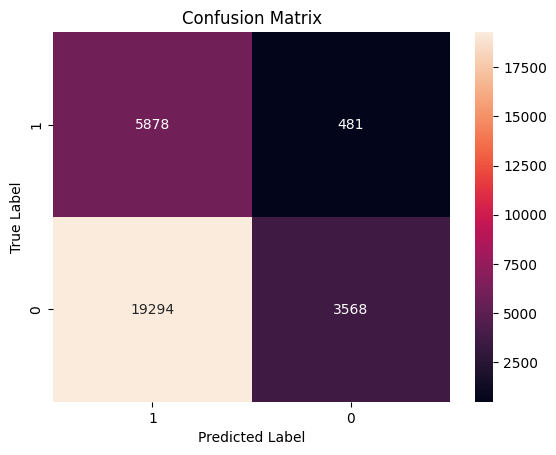

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt='0.0f')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.16      0.27     22862
         1.0       0.23      0.92      0.37      6359

    accuracy                           0.32     29221
   macro avg       0.56      0.54      0.32     29221
weighted avg       0.74      0.32      0.29     29221

